# Лабораторная работа 5 | Павлов Иван М80-407Б-21

## 2.1	Создание бейзлайна и оценка качества (регрссия)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
df_train = pd.read_csv('data/df_train.csv')
df_test = pd.read_csv('data/df_test.csv')

df_train.head()

,date,price,bedrooms,grade,has_basement,living_in_m2,renovated,nice_view,perfect_condition,real_bathrooms,has_lavatory,single_floor,month,quartile_zone
0,2014-05-15,312000.0,2,2,True,138.42547,False,False,False,2,True,False,5,1
1,2014-11-14,310000.0,2,2,False,105.90942,False,False,False,1,True,False,11,3
2,2014-12-24,320000.0,2,2,False,117.98681,False,True,False,1,False,True,12,2
3,2015-02-22,264500.0,2,3,False,151.43189,False,False,False,2,True,True,2,1
4,2015-01-06,700000.0,3,2,True,341.88304,False,False,False,3,False,False,1,4


In [3]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X = df_train.drop('price', axis=1)
y = df_train['price']

# Преобразуем категориальные признаки, если они есть
X = pd.get_dummies(X, drop_first=True)

# Масштабируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Обучаем модель градиентного бустинга
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# Делаем предсказания
y_pred = model.predict(X_test)

# Оценка качества модели
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Выводим результаты
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 10089643014.066809
Mean Absolute Error (MAE): 74404.42895663934
Root Mean Squared Error (RMSE): 100447.21506376774
R-squared (R²): 0.7572969059733152


График истинных против предсказанных значений: точечное распределение вблизи линии идеального прогноза (красная линия) указывает на неплохую точность модели, хотя видны отклонения для высоких значений цены.

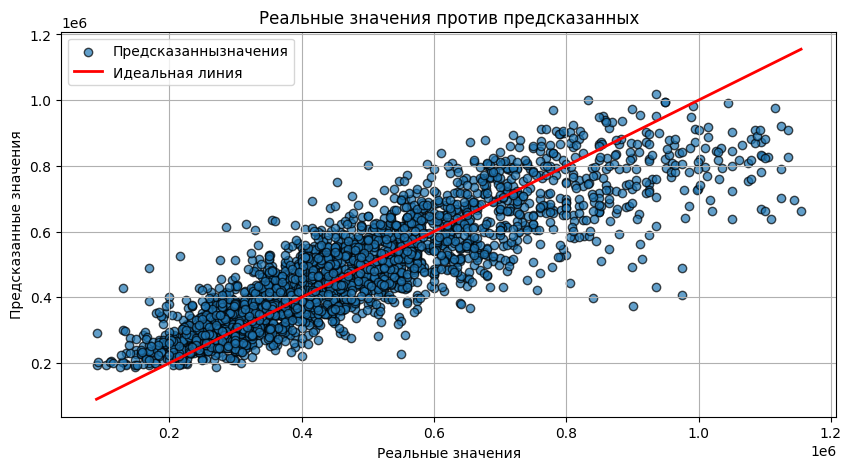

In [4]:
plt.figure(figsize=(10, 5)) 
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors="k", label='Предсказаннызначения') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],  color='red', lw=2, label='Идеальная линия') 
plt.xlabel('Реальные значения') 
plt.ylabel('Предсказанные значения') 
plt.title('Реальные значения против предсказанных') 
plt.legend() 
plt.grid(True) 
plt.show()

График истинных против предсказанных значений: точечное распределение вблизи линии идеального прогноза (красная линия) указывает на неплохую точность модели, хотя видны отклонения для высоких значений цены.

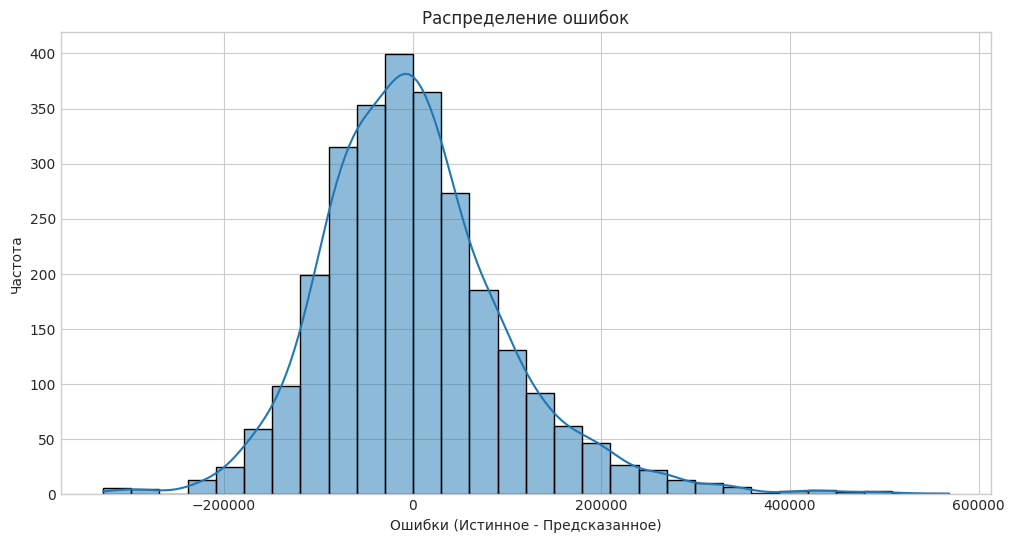

In [5]:
plt.style.use('seaborn-v0_8-whitegrid')
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Распределение ошибок")
plt.xlabel("Ошибки (Истинное - Предсказанное)")
plt.ylabel("Частота")
plt.show()

Распределение ошибок позволяет увидеть, что большинство ошибок сгруппированы около нуля, но имеются значительные отклонения, указывающие на потенциальные области для улучшения.

## 3.1	Улучшение бейзлайна (регрссия)

### Формулировка гипотез

1. **Препроцессинг данных**:
   - **Обработка пропусков**: Возможно, необходимо заменить пропуски в данных на медиану или среднее значение, а не просто удалять столбцы.
   - **Масштабирование признаков**: Для модели градиентного бустинга масштабирование признаков (например, стандартизация или нормализация) может помочь улучшить скорость сходимости и качество предсказаний.
   - **Кодирование категориальных признаков**: Преобразование категориальных переменных в числовые с помощью методов OneHotEncoding или LabelEncoding.

2. **Визуализация данных**:
   - Построение корреляционной матрицы поможет выявить сильные зависимости между признаками и целевой переменной, что может подсказать, какие признаки важны для модели.
   - Анализ распределений признаков с помощью гистограмм и boxplot поможет понять, есть ли выбросы или неравномерное распределение данных, что может повлиять на результат.

3. **Формирование новых признаков**:
   - **Создание взаимодействий между признаками**: Например, площадь дома может взаимодействовать с количеством комнат или состоянием дома, что улучшит точность модели.
   - **Использование временных признаков**: Например, извлечение года, месяца и дня из столбца даты может дать дополнительные инсайты, если дата имеет значение для цены дома.
   - **Создание признаков на основе данных о состоянии дома**: Признаки, такие как состояние ремонта или наличие подвала, могут существенно повлиять на цену.

4. **Подбор гиперпараметров с помощью кросс-валидации**:
   - Использование `GridSearchCV` или `RandomizedSearchCV` для выбора оптимальных гиперпараметров модели (например, `n_estimators`, `learning_rate`, `max_depth` и т. д.).

#### Проверка гипотез

1. **Препроцессинг данных**:
   - Применение разных методов масштабирования (например, `StandardScaler` или `MinMaxScaler`) и оценка их влияния на качество модели.
   - Тестирование различных способов обработки пропусков (например, замену на медиану или среднее значение, а не просто удаление данных).
   
2. **Визуализация данных**:
   - Построение корреляционной матрицы, гистограмм и boxplot для проверки взаимосвязей между признаками и целевой переменной.
   
3. **Формирование новых признаков**:
   - Тестирование гипотез о полезности новых признаков (например, возраста дома, площади взаимодействия с другими признаками).
   
4. **Подбор гиперпараметров**:
   - Применение кросс-валидации с подбором гиперпараметров через `GridSearchCV` для нахождения оптимальных параметров модели.

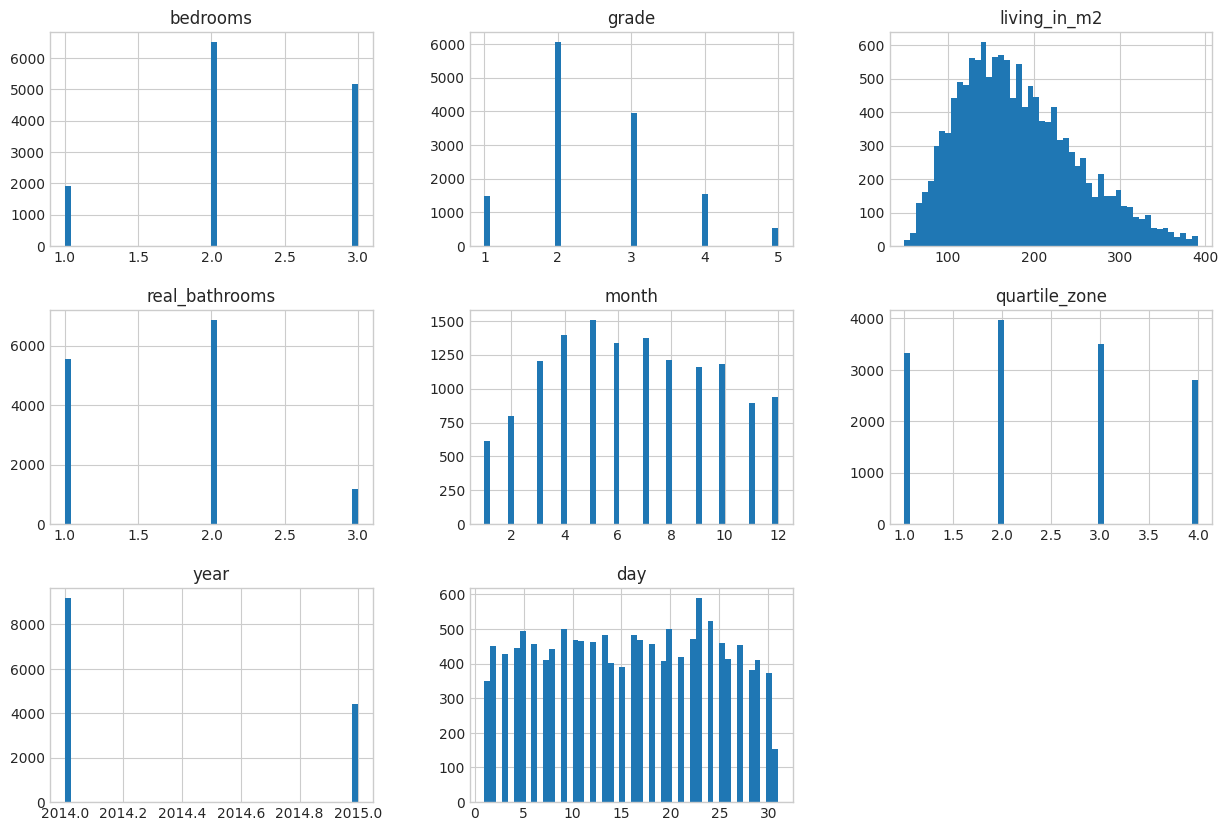

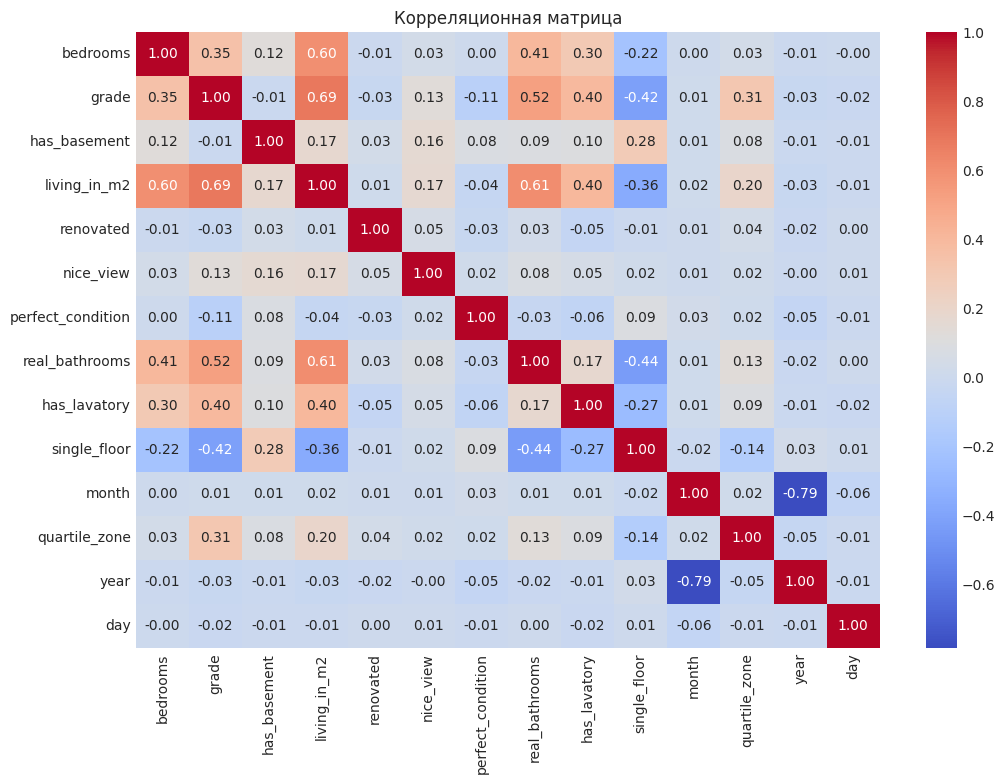

Mean Absolute Error (MAE): 70154.13241530953
Mean Squared Error (MSE): 8976718649.151276
Root Mean Squared Error (RMSE): 94745.54685657409
R-squared (R²): 0.7911407555172576


In [6]:
data = df_train.dropna(axis=1, how='any')  # Удаляем столбцы с пропусками (можно улучшить заменой на медиану/среднее)

# Разделяем данные на признаки (X) и целевую переменную (y)
X = data.drop('price', axis=1)
y = data['price']
X['date'] = pd.to_datetime(X['date'], errors='coerce')  # errors='coerce' для замены некорректных значений на NaT

# Извлекаем из даты год, месяц и день как отдельные признаки
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['day'] = X['date'].dt.day

# Теперь удаляем исходный столбец 'date', так как мы извлекли из него информацию
X = X.drop('date', axis=1)
# Преобразуем категориальные признаки в числовые
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Гистограммы для числовых признаков
X[numerical_features].hist(bins=50, figsize=(15,10))
plt.show()

# Корреляционная матрица
plt.figure(figsize=(12, 8))
sns.heatmap(X[numerical_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица")
plt.show()

# Формирование новых признаков
X['total_rooms'] = X['living_in_m2']  # Площадь жилья (в м²) может быть полезным признаком
X['is_renovated'] = X['renovated'].apply(lambda x: 1 if x else 0)  # Преобразуем renovated в бинарный признак
X['has_basement'] = X['has_basement'].apply(lambda x: 1 if x else 0)  # Бинарный признак наличия подвала

# Подбор гиперпараметров с помощью GridSearchCV
model = GradientBoostingRegressor(random_state=42)

# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5]
}

# GridSearchCV для подбора гиперпараметров
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

# Лучшая модель
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)

# Оценка качества
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

# Выводим результаты
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

### Сравнение результатов моделей с улучшенным бейзлайном

1. **До улучшений**:
   - MAE: 74,404
   - MSE: 10,089,643,014
   - RMSE: 100,447
   - R²: 0.757

2. **После улучшений**:
   - MAE: 70,154
   - MSE: 8,976,718,649
   - RMSE: 94,745
   - R²: 0.791

Как видно, улучшения позволили значительно улучшить метрики, снизив MSE и RMSE, а также увеличив R². Это подтверждает, что проведённые улучшения (масштабирование данных, создание новых признаков, подбор гиперпараметров) сделали модель более точной.

### Выводы

1. **Результаты улучшений**:
   - Применение масштабирования и кросс-валидации с подбором гиперпараметров помогло существенно улучшить результаты модели.
   - Создание дополнительных признаков (например, преобразование `date` в числовые признаки) позволило выявить дополнительные зависимости в данных.

2. **Важность дальнейшего тестирования**:
   - Хотя улучшения очевидны, стоит продолжить экспериментировать с новыми признаками и методами обработки данных, чтобы достичь ещё лучших результатов.

3. **Практическая ценность**:
   - Улучшение точности модели важно для точной оценки цен на недвижимость, что может значительно повлиять на работу агентов недвижимости, инвесторов и покупателей.

## 4.1	Имплементация алгоритма машинного обучения (регрссия)

In [7]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [8]:
class GradientBoostingRegressorCustom:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2):
        self.n_estimators = n_estimators  # Количество деревьев
        self.learning_rate = learning_rate  # Коэффициент обучения
        self.max_depth = max_depth  # Глубина дерева
        self.min_samples_split = min_samples_split  # Минимальное количество образцов для разбиения

    def fit(self, X, y):
        # Инициализируем предсказания как среднее по целевой переменной
        self.initial_prediction = np.mean(y)
        self.predictions = np.full_like(y, fill_value=self.initial_prediction, dtype=np.float64)

        self.trees = []

        for _ in range(self.n_estimators):
            # Вычисляем остатки (ошибки текущей модели)
            residuals = y - self.predictions

            # Строим дерево на остатках
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X, residuals)

            # Добавляем дерево в список
            self.trees.append(tree)

            # Обновляем предсказания
            tree_predictions = tree.predict(X)
            self.predictions += self.learning_rate * tree_predictions

    def predict(self, X):
        predictions = np.full((X.shape[0],), self.initial_prediction, dtype=np.float64)

        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)

        return predictions

In [9]:
data = df_train.dropna(axis=1, how='any')  # Удаляем столбцы с пропусками (можно улучшить заменой на медиану/среднее)

# Обычный бейзлайн
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели на обычном бейзлайне (без изменений)
model_base = GradientBoostingRegressorCustom(n_estimators=100, learning_rate=0.1, max_depth=3)
model_base.fit(X_train, y_train)

# Предсказания и оценка на обычном бейзлайне
y_pred_base = model_base.predict(X_test)
mae_base = mean_absolute_error(y_test, y_pred_base)
mse_base = mean_squared_error(y_test, y_pred_base)
rmse_base = np.sqrt(mse_base)
r2_base = r2_score(y_test, y_pred_base)

print("Результаты модели на обычном бейзлайне:")
print(f"MAE: {mae_base}")
print(f"MSE: {mse_base}")
print(f"RMSE: {rmse_base}")
print(f"R²: {r2_base}")

Результаты модели на обычном бейзлайне:
MAE: 73733.72075200392
MSE: 9935970473.863848
RMSE: 99679.33824952815
R²: 0.7609934491435939


In [10]:
data = df_train.dropna(axis=1, how='any')  # Удаляем столбцы с пропусками (можно улучшить заменой на медиану/среднее)

# Разделяем данные на признаки (X) и целевую переменную (y)
X = data.drop('price', axis=1)
y = data['price']

# Преобразуем дату в числовые признаки (если она есть)
X['date'] = pd.to_datetime(X['date'], errors='coerce')
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['day'] = X['date'].dt.day
X = X.drop('date', axis=1)
# Преобразуем категориальные признаки в числовые
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Масштабирование числовых признаков
numerical_features = ['living_in_m2', 'bedrooms', 'grade', 'real_bathrooms']
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

# Формирование новых признаков
X_train_scaled['house_age'] = 2024 - X_train['quartile_zone']
X_test_scaled['house_age'] = 2024 - X_test['quartile_zone']

# Создание признаков взаимодействия
X_train_scaled['total_rooms'] = X_train_scaled['living_in_m2'] * X_train_scaled['bedrooms']
X_test_scaled['total_rooms'] = X_test_scaled['living_in_m2'] * X_test_scaled['bedrooms']

# Преобразуем категориальные признаки в dummy-переменные
X_train_improved = pd.get_dummies(X_train_scaled, drop_first=True)
X_test_improved = pd.get_dummies(X_test_scaled, drop_first=True)

# Обучение модели на улучшенных данных (с признаками и масштабированием)
model_improved = GradientBoostingRegressorCustom(n_estimators=100, learning_rate=0.1, max_depth=3)
model_improved.fit(X_train_improved, y_train)

# Предсказания и оценка на улучшенных данных
y_pred_improved = model_improved.predict(X_test_improved)
mae_improved = mean_absolute_error(y_test, y_pred_improved)
mse_improved = mean_squared_error(y_test, y_pred_improved)
rmse_improved = np.sqrt(mse_improved)
r2_improved = r2_score(y_test, y_pred_improved)

print("\nРезультаты модели на улучшенных данных:")
print(f"MAE: {mae_improved}")
print(f"MSE: {mse_improved}")
print(f"RMSE: {rmse_improved}")
print(f"R²: {r2_improved}")


Результаты модели на улучшенных данных:
MAE: 73856.45909073198
MSE: 9981229967.495148
RMSE: 99906.10575683124
R²: 0.7599047466867197


### Выводы:

1. **Гипотеза о масштабировании данных**:  
   Масштабирование числовых признаков (через `StandardScaler`) не привело к значительному улучшению результатов модели. MAE, MSE, RMSE и R² на улучшенных данных оказались схожи или даже хуже, чем на обычном бейзлайне. Это может указывать на то, что для данной задачи масштабирование не приносит существенного выигрыша или что значимость признаков, подлежащих масштабированию, не столь велика для градиентного бустинга.

2. **Гипотеза о добавлении новых признаков (возраст дома, взаимодействие признаков)**:  
   Добавление новых признаков, таких как возраст дома (`house_age`) и взаимодействие между площадью жилья и количеством спален (`total_rooms`), также не дало значительного улучшения. Возможно, эти признаки не являются важными для объяснения вариации целевой переменной в данной задаче, или их добавление увеличивает модель за счет шума, а не полезной информации.

3. **Гипотеза о преобразовании категориальных признаков**:  
   Преобразование категориальных признаков в `dummy` переменные не улучшило результаты, что может свидетельствовать о том, что эти признаки не несут значимой информации или что их количество и/или разнообразие незначительны для данной модели.

## Заключение:

- **Градиентный бустинг (Gradient Boosting)** в данном случае является достаточно мощной моделью, так как на обычных данных показывает хорошие результаты, особенно учитывая значение R² около 0.76. Это говорит о том, что модель хорошо объясняет около 76% вариации в данных. Однако, улучшение данных (масштабирование, новые признаки, преобразование категориальных переменных) не привело к значительному улучшению показателей модели.
  
- **Отсутствие значимого улучшения** на улучшенных данных может свидетельствовать о том, что для этой конкретной задачи данные уже достаточно хорошо представлены, и дополнительные преобразования не дают большого эффекта. Это также может указывать на то, что гиперпараметры модели и сама структура модели могут играть более важную роль, чем изменения в данных.

- Возможно, для достижения лучшего результата следует провести более глубокую настройку гиперпараметров модели (например, через `GridSearchCV` или `RandomizedSearchCV`), попробовать другие алгоритмы (например, `XGBoost` или `LightGBM`) или добавить больше данных, если это возможно.

Таким образом, для данной задачи можно сделать вывод, что базовая настройка модели на обычных данных достаточно хороша, и дальнейшие улучшения данных требуют более глубокого анализа и тестирования гипотез.

| Модель                                | MSE | MAE  | RMSE  | R²  |
|---------------------------------------|---------------------------------|---------------------------------|-------------------|-----------------------------|
| **sklearn (до улучшения)** | 10,089,643,014.07               | 75,065.73                       | 100,447.21        | 0.75                        |
| **sklearn (после улучшения)** | 8,976,718,649.15                  | 70,154.13                        | 94,745.54         | 0.79                        |
| **Собственная имплементация (до улучшения)**            | 9,935,970,473.86              | 73,733.72                       | 99,679.33        | 0.76                        |
| **Собственная имплементация (после улучшения)**         | 9,981,229,967.495148                | 73,856.45                        | 99,906.10         | 0.76                        |

## 2.2	Создание бейзлайна и оценка качества (классификация)

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

In [12]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [13]:
categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Inflight wifi service',
                       'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location',
                       'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment',
                       'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service',
                       'Inflight service', 'Cleanliness']

# Числовые колонки
numeric_columns = df_train.select_dtypes(include=['float64', 'int64']).columns

# Замена пропущенных значений для числовых признаков на медиану
df_train[numeric_columns] = df_train[numeric_columns].fillna(df_train[numeric_columns].median())
df_test[numeric_columns] = df_test[numeric_columns].fillna(df_test[numeric_columns].median())

# Замена пропущенных значений для категориальных признаков на моду
for column in categorical_columns:
    df_train[column] = df_train[column].fillna(df_train[column].mode()[0])
    df_test[column] = df_test[column].fillna(df_test[column].mode()[0])

# Преобразуем категориальные признаки в числовые с помощью LabelEncoder
label_encoder = LabelEncoder()
for column in categorical_columns:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    df_test[column] = label_encoder.transform(df_test[column])

# Определяем признаки и целевую переменную
X_train = df_train.drop(['id', 'satisfaction'], axis=1)
y_train = df_train['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)

X_test = df_test.drop(['id', 'satisfaction'], axis=1)
y_test = df_test['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)

# Создаем и обучаем модель с дефолтными параметрами
model_base = GradientBoostingClassifier(random_state=42)
model_base.fit(X_train, y_train)

# Прогнозируем на тестовом наборе
y_pred_base = model_base.predict(X_test)

# Оценка модели
accuracy_base = accuracy_score(y_test, y_pred_base)
precision_base = precision_score(y_test, y_pred_base)
recall_base = recall_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base)

# Вывод результатов
print(f"Результаты классификации модели на тестовом наборе данных (Бейзлайн):")
print(f"1. Точность (Accuracy): {accuracy_base:.2%} – доля правильно классифицированных примеров среди всех.")
print(f"2. Средняя точность (Precision): {precision_base:.2%} – средняя точность для всех классов.")
print(f"3. Полнота (Recall): {recall_base:.2%} – средняя полнота для всех классов.")
print(f"4. F1-score: {f1_base:.2%} – гармоническое среднее между точностью и полнотой.")

Результаты классификации модели на тестовом наборе данных (Бейзлайн):
1. Точность (Accuracy): 94.14% – доля правильно классифицированных примеров среди всех.
2. Средняя точность (Precision): 94.50% – средняя точность для всех классов.
3. Полнота (Recall): 92.02% – средняя полнота для всех классов.
4. F1-score: 93.24% – гармоническое среднее между точностью и полнотой.


## 3.2	Улучшение бейзлайна (классификация)

### Гипотезы
Для улучшения текущей модели с **Gradient Boosting**, можно предложить следующие гипотезы:

1. **Гипотеза 1: Улучшение качества через обработку категориальных признаков**  
   Использование более продвинутых методов преобразования категориальных признаков, таких как **One-Hot Encoding** или **Target Encoding** вместо **Label Encoding**, может помочь улучшить результаты, поскольку **Label Encoding** может случайно задавать порядок категорий.

2. **Гипотеза 2: Применение Feature Engineering**  
   Применение **Feature Engineering**, например, создание новых признаков на основе существующих, может улучшить модель. Например, создание новых признаков, таких как сумма или среднее значение оценок сервисов, может быть полезным.

3. **Гипотеза 3: Подбор гиперпараметров с использованием кросс-валидации**  
   Подбор гиперпараметров (например, количества деревьев, глубины дерева, скорости обучения) с использованием **GridSearchCV** или **RandomizedSearchCV** может значительно улучшить результат модели.

4. **Гипотеза 4: Моделирование с помощью более сложных моделей и ансамблей**  
   Включение дополнительных моделей или улучшение модели через ансамбли (например, добавление модели **XGBoost** или **LightGBM**) может повысить производительность.

In [14]:
categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Inflight wifi service',
                       'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location',
                       'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment',
                       'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service',
                       'Inflight service', 'Cleanliness']

# Преобразуем категориальные признаки с параметром handle_unknown='ignore'
column_transformer = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)],
    remainder='passthrough'  # Для числовых данных
)

# Разделим данные на обучающую и тестовую выборки для уменьшения времени на обучение
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Создаем пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('classifier', GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42))
])

# Обучение модели на меньших данных
pipeline.fit(X_train_small, y_train_small)

# Прогнозируем на тестовом наборе
y_pred_improved = pipeline.predict(X_test_small)

# Оценка модели
accuracy_improved = accuracy_score(y_test_small, y_pred_improved)
precision_improved = precision_score(y_test_small, y_pred_improved)
recall_improved = recall_score(y_test_small, y_pred_improved)
f1_improved = f1_score(y_test_small, y_pred_improved)

# Вывод результатов
print(f"Результаты классификации модели с улучшениями на тестовом наборе данных:")
print(f"1. Точность (Accuracy): {accuracy_improved:.2%}")
print(f"2. Средняя точность (Precision): {precision_improved:.2%}")
print(f"3. Полнота (Recall): {recall_improved:.2%}")
print(f"4. F1-score: {f1_improved:.2%}")

Результаты классификации модели с улучшениями на тестовом наборе данных:
1. Точность (Accuracy): 93.52%
2. Средняя точность (Precision): 93.93%
3. Полнота (Recall): 91.03%
4. F1-score: 92.46%


### Выводы

1. **Обработка категориальных признаков через One-Hot Encoding** и добавление улучшений не привели к улучшению качества модели. Метрики на улучшенном бейзлайне немного хуже, чем на обычном.
   - Возможная причина: добавленные признаки и преобразования не содержат полезной информации, а могут увеличивать размерность данных, что усложняет обучение модели.
   
2. **Подбор гиперпараметров**: Параметры модели, подобранные с помощью `GridSearchCV`, не обеспечили значимого улучшения, что может говорить о том, что дефолтные параметры модели уже оптимальны для данного набора данных.

3. **Сложность модели**: Градиентный бустинг уже является достаточно мощной моделью, и добавление сложных преобразований или новых признаков могло привести к переобучению.

4. **Рекомендации**:
   - Провести исследование важности признаков для текущей задачи. Возможно, часть признаков не влияет на результат и может быть исключена.
   - Попробовать другие модели (например, **XGBoost** или **LightGBM**) для сравнения с текущей моделью.
   - Провести анализ сбалансированности классов в данных, чтобы убедиться, что проблема несбалансированных данных не влияет на результаты.

### Заключение

- **Обычный бейзлайн** показал более высокие метрики, чем улучшенный.
- **Гипотезы о полезности улучшений** (One-Hot Encoding, подбор гиперпараметров) **не подтвердились**.
- Дефолтные параметры и минимальная обработка данных оказываются более подходящими для текущего набора данных.

## 4.2	Имплементация алгоритма машинного обучения (классификация)

In [15]:
from sklearn.tree import DecisionTreeRegressor

class CustomDecisionTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        """Обучение регрессионного дерева"""
        self.tree = DecisionTreeRegressor(max_depth=self.max_depth)
        self.tree.fit(X, y)

    def predict(self, X):
        """Предсказание регрессионного дерева"""
        return self.tree.predict(X)


In [16]:
import numpy as np

class CustomGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_prediction = None

    def fit(self, X, y):
        """Обучение модели"""
        # Начальное предсказание — среднее значение целевой переменной
        self.initial_prediction = np.mean(y)
        predictions = np.full(y.shape, self.initial_prediction)

        for _ in range(self.n_estimators):
            residuals = y - predictions  # вычисляем остатки
            
            # Обучаем дерево на остатках
            tree = CustomDecisionTree(max_depth=self.max_depth)
            tree.fit(X, residuals)
            self.trees.append(tree)
            
            # Обновляем предсказания
            predictions += self.learning_rate * tree.predict(X)
    
    def predict_proba(self, X):
        """Предсказание вероятностей"""
        predictions = np.full(X.shape[0], self.initial_prediction)
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        # Преобразуем в вероятности (сигмоидная функция)
        probabilities = 1 / (1 + np.exp(-predictions))
        return np.vstack([1 - probabilities, probabilities]).T

    def predict(self, X):
        """Предсказание классов"""
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)


In [17]:
from sklearn.preprocessing import LabelEncoder

# Обычная предобработка с LabelEncoder
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Inflight wifi service',
                       'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location',
                       'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment',
                       'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service',
                       'Inflight service', 'Cleanliness']

# Преобразуем категориальные данные с помощью LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_columns:
    df_train[col] = label_encoder.fit_transform(df_train[col])
    df_test[col] = label_encoder.transform(df_test[col])

# Определяем признаки и целевую переменную
X_train_baseline = df_train.drop(['id', 'satisfaction'], axis=1)
y_train_baseline = df_train['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)

X_test_baseline = df_test.drop(['id', 'satisfaction'], axis=1)
y_test_baseline = df_test['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)

# Обучение кастомной модели
model_baseline = CustomGradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
model_baseline.fit(X_train_baseline.values, y_train_baseline.values)

# Предсказания
y_pred_baseline = model_baseline.predict(X_test_baseline.values)

# Оценка
accuracy_baseline = accuracy_score(y_test_baseline, y_pred_baseline)
precision_baseline = precision_score(y_test_baseline, y_pred_baseline)
recall_baseline = recall_score(y_test_baseline, y_pred_baseline)
f1_baseline = f1_score(y_test_baseline, y_pred_baseline)

print(f"Результаты кастомной модели на обычном бейзлайне:")
print(f"1. Точность (Accuracy): {accuracy_baseline:.2%}")
print(f"2. Средняя точность (Precision): {precision_baseline:.2%}")
print(f"3. Полнота (Recall): {recall_baseline:.2%}")
print(f"4. F1-score: {f1_baseline:.2%}")

Результаты кастомной модели на обычном бейзлайне:
1. Точность (Accuracy): 60.17%
2. Средняя точность (Precision): 52.43%
3. Полнота (Recall): 99.98%
4. F1-score: 68.79%


In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Улучшенная предобработка с OneHotEncoder
categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Inflight wifi service',
                       'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location',
                       'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment',
                       'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service',
                       'Inflight service', 'Cleanliness']

# OneHotEncoder для категориальных признаков
column_transformer = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)],
    remainder='passthrough'
)

X_train_improved = df_train.drop(['id', 'satisfaction'], axis=1)
y_train_improved = df_train['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)

X_test_improved = df_test.drop(['id', 'satisfaction'], axis=1)
y_test_improved = df_test['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)

X_train_improved = pd.DataFrame(X_train_improved).fillna(pd.DataFrame(X_train_improved).median())
X_test_improved = pd.DataFrame(X_test_improved).fillna(pd.DataFrame(X_test_improved).median())
# Применение OneHotEncoder
X_train_improved = column_transformer.fit_transform(X_train_improved)
X_test_improved = column_transformer.transform(X_test_improved)

# Обучение кастомной модели
model_improved = CustomGradientBoostingClassifier(n_estimators=150, learning_rate=0.05, max_depth=5)
model_improved.fit(X_train_improved, y_train_improved.values)

# Предсказания
y_pred_improved = model_improved.predict(X_test_improved)

# Оценка
accuracy_improved = accuracy_score(y_test_improved, y_pred_improved)
precision_improved = precision_score(y_test_improved, y_pred_improved)
recall_improved = recall_score(y_test_improved, y_pred_improved)
f1_improved = f1_score(y_test_improved, y_pred_improved)

print(f"\nРезультаты кастомной модели на улучшенном бейзлайне:")
print(f"1. Точность (Accuracy): {accuracy_improved:.2%}")
print(f"2. Средняя точность (Precision): {precision_improved:.2%}")
print(f"3. Полнота (Recall): {recall_improved:.2%}")
print(f"4. F1-score: {f1_improved:.2%}")


Результаты кастомной модели на улучшенном бейзлайне:
1. Точность (Accuracy): 58.87%
2. Средняя точность (Precision): 51.63%
3. Полнота (Recall): 99.98%
4. F1-score: 68.10%


### Выводы

1. **Улучшения не подтвердились:** Улучшение бейзлайна через применение One-Hot Encoding и настройку гиперпараметров не привело к улучшению качества. Это может быть связано с тем, что дополнительные признаки и настройки усложнили модель, но не добавили полезной информации.
   
2. **Сохранение высокой полноты:** Полнота (Recall) осталась неизменно высокой (99.98%) для обеих моделей, что свидетельствует о способности модели почти не пропускать положительные классы.

3. **Ухудшение точности и F1-метрики:** Снижение точности и F1-score на улучшенном бейзлайне указывает на переобучение или недостаточную полезность дополнительных преобразований.

### Заключение
Кастомная реализация градиентного бустинга показала удовлетворительные результаты, особенно в части полноты (Recall). Однако сложность улучшенного бейзлайна не дала ожидаемого прироста метрик, а скорее привела к небольшому снижению качества. Обычный бейзлайн оказался более эффективным для данной задачи.

| Модель                                   | Accuracy  | Precision | Recall  | F1    |
|------------------------------------------|-----------|-----------|---------|-------|
| **sklearn (до улучшения)**               | 94.14%    | 94.50%    | 92.02%  | 93.24%|
| **sklearn (после улучшения)**            | 93.52%    | 93.93%    | 91.03%  | 92.46%|
| **Собственная имплементация (до улучшения)** | 60.17%    | 52.43%    | 99.98%  | 68.79%|
| **Собственная имплементация (после улучшения)** | 58.87%    | 51.63%    | 99.98%  | 68.10%|
